In [28]:
# SETUP & DEPENDENCIES
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style="whitegrid")

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    precision_recall_fscore_support,
    confusion_matrix,
    accuracy_score,
)

import joblib

import tqdm

from conformal import ConformalPredictor

In [29]:
# RUNTIME DEVICE
# - Prefer GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [30]:
# PATHS & GLOBAL HYPERPARAMETERS
ROOT = Path.cwd()
ARTIFACTS = ROOT / "artifacts"; ARTIFACTS.mkdir(parents=True, exist_ok=True)
CKPTS = ROOT / "checkpoints"; CKPTS.mkdir(parents=True, exist_ok=True)
BEST_MODEL_PATH = CKPTS / "best_model.pth"
SCALER_PATH = ARTIFACTS / "scaler.gz"

SELECT_SCORE   = "MAE"       # "MSE" or "MAE" or "MAXAE"
TRAD_PCT       = 0.95        # τ_95 for traditional thresholding
TRAD_SOURCE    = "trainval"  # "trainval" or "calib" for how to estimate τ
ALPHA = 0.05    # target miscoverage (coverage = 1 - ALPHA)
ALPHA_MINMAX  = (0.001, 0.20)   # bounds for adaptive α
ADAPT_GAMMA   = 0.01  # learning rate for adaptive α
N_ROWS_VIEW   = 5000    # x-range in plots
SEQUENCE_LENGTH = 20
BATCH_SIZE = 128
K_VALUES = [250, 10000, 1000000]
SCORE_MODES = ["MSE", "MAE", "MAXAE"]

TRAIN = False
EPOCHS = 10
PATIENCE = 3
LR = 1e-3

In [31]:
DATASETS = [
    ("dos",   "datasets/DoS_attack_dataset.csv"),
    ("fuzzy", "datasets/Fuzzy_attack_dataset.csv"),
    ("gear",  "datasets/gear_attack_dataset.csv"),
    ("rpm",   "datasets/RPM_attack_dataset.csv"),
]


Data Preprocessing

In [32]:
# LOAD BENIGN DATA
normal_df = pd.read_csv('datasets/Attack_free_dataset.csv')
print("Attack_free_dataset.csv loaded successfully.")
print(f"Shape: {normal_df.shape}")

Attack_free_dataset.csv loaded successfully.
Shape: (988871, 12)


In [33]:
# QUICK INSPECTION
print("\nFirst 20 rows of the dataset:")
display(normal_df.head(20))


First 20 rows of the dataset:


,timestamp,can_id,flags,dlc,data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7
0,1.479121e+09,848,0,8,5,40,132,102,109,0,0,162
1,1.479121e+09,704,0,8,20,0,0,0,0,0,0,0
2,1.479121e+09,1072,0,8,0,0,0,0,0,0,0,0
3,1.479121e+09,1201,0,8,0,0,0,0,0,0,0,0
4,1.479121e+09,497,0,8,0,0,0,0,0,0,0,0
5,1.479121e+09,339,0,8,0,0,0,255,0,255,0,0
6,1.479121e+09,2,0,8,0,0,0,0,0,0,0,10
7,1.479121e+09,399,0,8,254,54,0,0,0,60,0,0
8,1.479121e+09,304,0,8,3,128,0,255,33,128,0,157
9,1.479121e+09,305,0,8,0,128,0,0,45,127,0,151


In [34]:
# QUICK INFO
print("\nDataset Information:")
normal_df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988871 entries, 0 to 988870
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   timestamp  988871 non-null  float64
 1   can_id     988871 non-null  int64  
 2   flags      988871 non-null  int64  
 3   dlc        988871 non-null  int64  
 4   data_0     988871 non-null  int64  
 5   data_1     988871 non-null  int64  
 6   data_2     988871 non-null  int64  
 7   data_3     988871 non-null  int64  
 8   data_4     988871 non-null  int64  
 9   data_5     988871 non-null  int64  
 10  data_6     988871 non-null  int64  
 11  data_7     988871 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 90.5 MB


Features / Data Splitting

In [35]:
# FEATURE ENGINEERING & SPLITTING
# - time_delta = diff of timestamp
# - Split: 80/10/10 into Train / Val / Calib on benign only
normal_df['time_delta'] = normal_df['timestamp'].diff().fillna(0)

features = ['time_delta', 'can_id', 'dlc'] + [f'data_{i}' for i in range(8)]
data = normal_df[features].values

n = len(data)
train_end = int(0.80 * n)
val_end   = int(0.90 * n)

X_train_raw = data[:train_end]
X_val_raw   = data[train_end:val_end]
X_calib_raw = data[val_end:]

print(f"Training={len(X_train_raw)}\nValidation={len(X_val_raw)}\nCalibration={len(X_calib_raw)}")

Training=791096
Validation=98887
Calibration=98888


In [36]:
# SAMPLE TRAIN VIEW
print("\nFirst 20 rows of the training set:")
display(pd.DataFrame(X_train_raw, columns=features).head(20))


First 20 rows of the training set:


,time_delta,can_id,dlc,data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7
0,0.000000,848.0,8.0,5.0,40.0,132.0,102.0,109.0,0.0,0.0,162.0
1,0.000221,704.0,8.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000554,1072.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000238,1201.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000248,497.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000248,339.0,8.0,0.0,0.0,0.0,255.0,0.0,255.0,0.0,0.0
6,0.000252,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
7,0.000239,399.0,8.0,254.0,54.0,0.0,0.0,0.0,60.0,0.0,0.0
8,0.000241,304.0,8.0,3.0,128.0,0.0,255.0,33.0,128.0,0.0,157.0
9,0.000244,305.0,8.0,0.0,128.0,0.0,0.0,45.0,127.0,0.0,151.0


In [37]:
# SCALING & PERSISTENCE
# - Fit MinMax on Train only, then transform (Train/Val/Calib)
# - Persist scaler to reproduce inference-time transforms
scaler = MinMaxScaler()
scaler.fit(X_train_raw)

X_train_scaled = scaler.transform(X_train_raw)
X_val_scaled = scaler.transform(X_val_raw)
X_calib_scaled = scaler.transform(X_calib_raw)

joblib.dump(scaler, SCALER_PATH)
print(f"Scaler fitted on training data and saved to {SCALER_PATH}")

Scaler fitted on training data and saved to /home/student/Anthony/can/CAN-bus-conformal-IDS/artifacts/scaler.gz


In [38]:
# SANITY CHECK POST-SCALING
print("\nFirst 20 rows of the training set:")
display(pd.DataFrame(X_train_scaled, columns=features).head(20))


First 20 rows of the training set:


,time_delta,can_id,dlc,data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7
0,0.000000,0.504172,1.0,0.019608,0.156863,0.517647,0.400000,0.427451,0.000000,0.000000,0.635294
1,0.034256,0.418355,1.0,0.078431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.085843,0.637664,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.036880,0.714541,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.038469,0.294994,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.038432,0.200834,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
6,0.039060,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039216
7,0.037027,0.236591,1.0,0.996078,0.211765,0.000000,0.000000,0.000000,0.235294,0.000000,0.000000
8,0.037360,0.179976,1.0,0.011765,0.501961,0.000000,1.000000,0.129412,0.501961,0.000000,0.615686
9,0.037803,0.180572,1.0,0.000000,0.501961,0.000000,0.000000,0.176471,0.498039,0.000000,0.592157


In [39]:
# SEQUENCE BUILDER & DATALOADERS
# - Convert row-wise features to (seq_len, feat_dim) windows
# - Create PyTorch datasets/loaders for AE (input == target)
def create_sequences(data, sequence_length):
    if len(data) < sequence_length:
        return np.empty((0, sequence_length, data.shape[1]), dtype=np.float32)
    out = np.empty((len(data) - sequence_length + 1, sequence_length, data.shape[1]), dtype=np.float32)
    for i in range(out.shape[0]):
        out[i] = data[i:i+sequence_length]
    return out

train_sequences = create_sequences(X_train_scaled, SEQUENCE_LENGTH)
val_sequences = create_sequences(X_val_scaled, SEQUENCE_LENGTH)
calib_sequences = create_sequences(X_calib_scaled, SEQUENCE_LENGTH)

print(f"Shape of training sequences: {train_sequences.shape}\nShape of validation sequences: {val_sequences.shape}\nShape of calibration sequences: {calib_sequences.shape}")

train_sequences_tensor = torch.tensor(train_sequences, dtype=torch.float32)
val_sequences_tensor = torch.tensor(val_sequences, dtype=torch.float32)
calib_sequences_tensor = torch.tensor(calib_sequences, dtype=torch.float32)

train_dataset = TensorDataset(train_sequences_tensor, train_sequences_tensor)
val_dataset = TensorDataset(val_sequences_tensor, val_sequences_tensor)
calib_dataset = TensorDataset(calib_sequences_tensor, calib_sequences_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
calib_loader = DataLoader(calib_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_loader)}\nNumber of validation batches: {len(val_loader)}\nNumber of calibration batches: {len(calib_loader)}")

Shape of training sequences: (791077, 20, 11)
Shape of validation sequences: (98868, 20, 11)
Shape of calibration sequences: (98869, 20, 11)
Number of training batches: 6181
Number of validation batches: 773
Number of calibration batches: 773


Model

In [40]:
# MODEL DEFINITION (LSTM AUTOENCODER)
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) 
        
    def forward(self, x):
        _, (hidden, cell) = self.lstm(x)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(output_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, hidden, cell):
        output, _ = self.lstm(x, (hidden, cell)) 
        reconstruction = self.fc(output)
        return reconstruction

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, num_layers=1):
        super().__init__()
        self.seq_len = seq_len
        self.encoder = Encoder(input_dim, hidden_dim, num_layers)
        self.decoder = Decoder(input_dim, hidden_dim, num_layers)
        
    def forward(self, x):
        hidden, cell = self.encoder(x)
        decoder_input = torch.zeros_like(x).to(device)
        
        reconstruction = self.decoder(decoder_input, hidden, cell)
        return reconstruction


In [41]:
# MODEL INSTANTIATION & OPTIMIZER
# - Default MSE loss for AE
# - Optimizer: Adam
INPUT_DIM = train_sequences.shape[2] 
HIDDEN_DIM = 64

model = LSTMAutoencoder(INPUT_DIM, HIDDEN_DIM, SEQUENCE_LENGTH).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

LSTMAutoencoder(
  (encoder): Encoder(
    (lstm): LSTM(11, 64, batch_first=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(11, 64, batch_first=True)
    (fc): Linear(in_features=64, out_features=11, bias=True)
  )
)


In [42]:
# TRAINING LOOP (EARLY STOPPING ON VAL LOSS)
def train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, patience=PATIENCE):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best, bad = np.inf, 0

    for ep in range(epochs):
        model.train()
        tr_loss = 0.0
        bar = tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs}", leave=False)
        for xb, yb in bar:
            xb, yb = xb.float().to(device), yb.float().to(device)
            opt.zero_grad()
            yhat = model(xb)
            loss = criterion(yhat, yb)
            loss.backward(); opt.step()
            tr_loss += loss.item()
            bar.set_postfix(loss=f"{loss.item():.6f}")
        tr_loss /= max(1, len(train_loader))

        model.eval()
        va_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.float().to(device), yb.float().to(device)
                va_loss += criterion(model(xb), yb).item()
        va_loss /= max(1, len(val_loader))
        print(f"Epoch {ep+1}: train {tr_loss:.6f} | val {va_loss:.6f}")

        if va_loss < best:
            best = va_loss; bad = 0
            torch.save({"model_state_dict": model.state_dict()}, BEST_MODEL_PATH)
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping.")
                break

if TRAIN:
    train_model(model, train_loader, val_loader)

In [43]:
# LOAD BEST CHECKPOINT FOR INFERENCE
checkpoint = torch.load(BEST_MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

LSTMAutoencoder(
  (encoder): Encoder(
    (lstm): LSTM(11, 64, batch_first=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(11, 64, batch_first=True)
    (fc): Linear(in_features=64, out_features=11, bias=True)
  )
)

In [44]:
# SCORING UTILITIES
# - score_batch: compute nonconformity per sequence (MSE/MAE/MAXAE)
# - predict_scores: batched inference over a DataLoader

def score_batch(pred, tgt, mode: str):
    """Return (B,) score per sequence according to nonconformity mode."""
    diff = (pred - tgt).abs()
    if mode == "MSE":
        return (diff**2).mean(dim=(1, 2)).cpu().numpy()
    if mode == "MAE":
        return diff.mean(dim=(1, 2)).cpu().numpy()
    if mode == "MAXAE":
        return diff.max(dim=2).values.max(dim=1).values.cpu().numpy()
    raise ValueError(f"Unknown mode: {mode}")

def predict_scores(model, loader, mode: str):
    out = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.float().to(device), yb.float().to(device)
            yhat = model(xb)
            out.append(score_batch(yhat, yb, mode))
    return np.concatenate(out) if out else np.array([])

def benign_scores_for_threshold(mode: str) -> np.ndarray:
    """
    Return benign scores used to compute the traditional threshold τ.
    Default: Train+Val (no calibration leakage).
    """
    parts = []
    if TRAD_SOURCE.lower() in {"trainval", "train", "val"}:
        if TRAD_SOURCE.lower() in {"trainval", "train"}:
            parts.append(predict_scores(model, train_loader, mode))
        if TRAD_SOURCE.lower() in {"trainval", "val"}:
            parts.append(predict_scores(model, val_loader, mode))
    elif TRAD_SOURCE.lower() == "calib":
        parts.append(predict_scores(model, calib_loader, mode))
    else:
        raise ValueError(f"Unknown TRAD_SOURCE={TRAD_SOURCE}")
    return np.concatenate(parts) if parts else np.array([])

def compute_tau(scores: np.ndarray, pct: float) -> float:
    if scores.size == 0:
        raise ValueError("[traditional] No benign scores to compute τ.")
    return float(np.quantile(scores, pct))

In [45]:
# SCORE FROM CSV (ATTACK FILES)
# - Build time_delta, scale, window into sequences, infer scores
def scores_from_csv(csv_path, features, scaler, L, batch_size=BATCH_SIZE, mode="MAE"):
    df = pd.read_csv(csv_path)
    df["time_delta"] = df["timestamp"].diff().fillna(0)
    X = scaler.transform(df[features].values)
    if len(X) < L:
        return np.array([]), np.array([]) 

    seqs = create_sequences(X, L)
    dl = DataLoader(TensorDataset(torch.tensor(seqs, dtype=torch.float32),
                                  torch.tensor(seqs, dtype=torch.float32)),
                    batch_size=batch_size, shuffle=False)
    scores = predict_scores(model, dl, mode)

    # Sequence label: mark a sequence as attack if any row in its window is attack
    seq_labels = np.array([])
    if "label" in df.columns and len(df) >= L:
        rows = (
            (df["label"].astype(str).str.upper().isin(["1","T","TRUE"])) |
            (df["label"].astype(str).isin(["1"]))
        ).astype(int).to_numpy()
        seq_labels = np.array([1 if np.any(rows[i:i+L]) else 0 for i in range(len(rows)-L+1)], dtype=int)
    return scores, seq_labels

In [46]:
# PLOTTING: COVERAGE ONLY (FIXED THRESHOLD)
def plot_coverage_only_traditional(
    scores: np.ndarray,
    tau: float,
    L: int,
    atk_row_start: int | None,
    save_path,
    attack_name: str = "DoS",
    n_rows_view: int = 5000,
):
    if scores.size == 0:
        print("[plot_coverage_only_traditional] Nothing to plot.")
        return

    x_end = np.arange(scores.size) + (L - 1)
    mask = x_end < n_rows_view
    if not np.any(mask):
        print(f"[plot_coverage_only_traditional] No sequences within first {n_rows_view} rows.")
        return

    x = x_end[mask]
    s = scores[mask]
    covered = (s <= tau).astype(int)
    coverage = np.cumsum(covered) / np.arange(1, covered.size + 1)

    plt.figure(figsize=(11, 4))
    plt.plot(x, coverage, linewidth=2, label="coverage (≤ τ)")
    if atk_row_start is not None and atk_row_start <= x[-1]:
        plt.axvline(atk_row_start, linestyle=":", linewidth=1.25, label="attack start")
    plt.ylim(0, 1)
    plt.xlabel("row index")
    plt.ylabel("coverage (≤ τ)")
    plt.title(f"{attack_name.upper()} – coverage only (traditional threshold)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()


In [47]:
# PLOTTING HELPERS: HISTOGRAM / CONFUSION MATRIX
def plot_hist(arr, title, xlabel, save_path=None, vline=None, vlabel=None):
    plt.figure(figsize=(10,4))
    sns.histplot(arr, bins=50, kde=True)
    if vline is not None:
        plt.axvline(vline, linestyle="--", linewidth=2, label=vlabel)
        plt.legend()
    plt.title(title); plt.xlabel(xlabel); plt.ylabel("Count"); plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=150)
    plt.show()

def plot_cm(y_true, y_pred, title, save_path=None):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    plt.figure(figsize=(4.2,3.6))
    sns.heatmap(cm, annot=True, fmt='d', cbar=False,
                xticklabels=["Normal","Attack"], yticklabels=["Normal","Attack"])
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=150)
    plt.show()
    return cm

# TRADITIONAL TIMELINE PLOT (NO CONFORMAL)
def plot_rows_timeline_traditional(
    scores: np.ndarray,
    L: int,
    tau: float,
    atk_row_start: int | None,
    save_path,
    mode_label: str = "MSE",
    attack_name: str = "DoS",
    smooth: int = 25,
    n_rows_view: int = 5000,
    y_clip: float = 0.995,
    y_pad: float = 1.05,
):
    COL_SCORE, COL_TAU, COL_ATTACK, COL_COVER = "#1f77b4", "#2ca02c", "#ff7f0e", "#d62728"

    if scores.size == 0:
        print("[plot_rows_timeline_traditional] Nothing to plot.")
        return

    x_end = np.arange(scores.size) + (L - 1)
    mask = x_end < n_rows_view
    if not np.any(mask):
        print(f"[plot_rows_timeline_traditional] No sequences within first {n_rows_view} rows.")
        return

    x = x_end[mask]
    s = scores[mask]
    covered = (s <= tau).astype(int)
    coverage = np.cumsum(covered) / np.arange(1, covered.size + 1)

    s_smooth = pd.Series(s).rolling(max(5, smooth), min_periods=1).mean().to_numpy()

    fig, ax1 = plt.subplots(figsize=(11, 4))
    ax1.plot(x, s_smooth, color=COL_SCORE, linewidth=2, label=f"{mode_label} (reconstruction)")
    ax1.axhline(tau, color=COL_TAU, linestyle="--", linewidth=1.8, label=r"threshold $\tau_{95}$")

    if atk_row_start is not None and atk_row_start <= x[-1]:
        ax1.axvline(atk_row_start, color=COL_ATTACK, linestyle=":", linewidth=1.4, label="attack start")

    ax1.set_xlabel("row index")
    ax1.set_ylabel(f"{mode_label} score", color=COL_SCORE)
    ax1.tick_params(axis="y", colors=COL_SCORE)

    ymax = float(np.quantile(s, y_clip)) * y_pad
    if not np.isfinite(ymax) or ymax <= 0:
        ymax = max(1.0, float(s.max()) * y_pad)
    ax1.set_ylim(0.0, ymax)

    ax2 = ax1.twinx()
    ax2.plot(x, coverage, color=COL_COVER, linewidth=2, label="coverage (≤ τ)")
    ax2.set_ylabel("coverage", color=COL_COVER)
    ax2.tick_params(axis="y", colors=COL_COVER)
    ax2.set_ylim(0, 1)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="best")
    plt.title(f"{attack_name.upper()} – coverage vs {mode_label} (traditional τ₉₅), first {n_rows_view} rows")
    plt.tight_layout(); plt.savefig(save_path, dpi=150); plt.show()

# FIXED TIMELINE PLOT (WITH CONFORMAL)
def plot_rows_timeline_fixed(
    scores: np.ndarray,
    seq_labels: np.ndarray | None,
    q_fixed: float,
    alpha: float,
    L: int,
    atk_row_start: int | None,
    save_path,
    mode_label: str = "MSE",
    attack_name: str = "DoS",
    smooth: int = 25,
    n_rows_view: int = 5000, 
    y_clip: float = 0.995,
    y_pad: float = 1.05,
):
    COL_MSE, COL_Q, COL_ATTACK, COL_COVER, COL_TARGET = "#1f77b4", "#2ca02c", "#ff7f0e", "#d62728", "#7f7f7f"

    Nseq = scores.size
    if Nseq == 0:
        print("[plot_rows_timeline_fixed] Nothing to plot.")
        return

    # map each sequence s -> row index of its window END
    x_end = np.arange(Nseq) + (L - 1)

    # keep only sequences whose end-row is within the first n_rows_view rows
    mask = x_end < n_rows_view
    if not np.any(mask):
        print(f"[plot_rows_timeline_fixed] No sequences end before row {n_rows_view}.")
        return

    x = x_end[mask]
    s = scores[mask]

    covered = (s <= q_fixed).astype(int)
    coverage = np.cumsum(covered) / np.arange(1, covered.size + 1)

    s_smooth = pd.Series(s).rolling(max(5, smooth), min_periods=1).mean().to_numpy()

    fig, ax1 = plt.subplots(figsize=(11, 4))
    ax1.plot(x, s_smooth, color=COL_MSE, linewidth=2, label=f"{mode_label} (reconstruction)")
    ax1.axhline(q_fixed, color=COL_Q, linestyle="--", linewidth=1.8, label=fr"threshold $\hat{{q}}$ (α={alpha})")

    if atk_row_start is not None:
        ax1.axvline(atk_row_start, color=COL_ATTACK, linestyle=":", linewidth=1.4, label="attack start")

    ax1.set_xlabel("row index")
    ax1.set_ylabel(f"{mode_label} score", color=COL_MSE)
    ax1.tick_params(axis="y", colors=COL_MSE)

    # y-scale to see fluctuations
    ymax = float(np.quantile(s, y_clip)) * y_pad
    if not np.isfinite(ymax) or ymax <= 0:
        ymax = max(1.0, float(s.max()) * y_pad)
    ax1.set_ylim(0.0, ymax)

    ax2 = ax1.twinx()
    ax2.plot(x, coverage, color=COL_COVER, linewidth=2, label="coverage")
    ax2.axhline(1 - alpha, color=COL_TARGET, linestyle="--", linewidth=1.5, label=f"target 1-α = {1 - alpha:.2f}")
    ax2.set_ylabel("coverage (≤ q̂)", color=COL_COVER)
    ax2.tick_params(axis="y", colors=COL_COVER)
    ax2.set_ylim(0, 1)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="best")

    plt.title(f"{attack_name.upper()} – coverage vs {mode_label} (fixed $\hat{{q}}$), first {n_rows_view} rows")
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()

# ADAPTIVE TIMELINE PLOT (WITH CONFORMAL)
def plot_rows_timeline_adaptive(
    scores: np.ndarray,
    seq_labels: np.ndarray | None,
    alpha_series: np.ndarray,
    q_series: np.ndarray,
    alpha0: float,
    L: int,
    atk_row_start: int | None,
    save_path,
    mode_label: str = "MSE",
    attack_name: str = "DoS",
    smooth: int = 25,
    n_rows_view: int = 5000,
    y_clip: float = 0.995,
    y_pad: float = 1.05,
):
    COL_MSE, COL_Q, COL_ATTACK, COL_COVER, COL_TARGET, COL_ALPHA = \
        "#1f77b4", "#2ca02c", "#ff7f0e", "#d62728", "#7f7f7f", "#9467bd"

    if scores.size == 0:
        print("[plot_rows_timeline_adaptive] Nothing to plot.")
        return

    x_end = np.arange(scores.size) + (L - 1)
    mask = x_end < n_rows_view
    if not np.any(mask):
        print(f"[plot_rows_timeline_adaptive] No sequences within first {n_rows_view} rows.")
        return

    x = x_end[mask]
    s = scores[mask]
    q = q_series[mask]
    a = alpha_series[mask]

    covered = (s <= q).astype(int)
    coverage = np.cumsum(covered) / np.arange(1, covered.size + 1)

    s_smooth = pd.Series(s).rolling(max(5, smooth), min_periods=1).mean().to_numpy()
    q_smooth = pd.Series(q).rolling(max(5, smooth), min_periods=1).mean().to_numpy()

    fig, ax1 = plt.subplots(figsize=(11, 4))
    ax1.plot(x, s_smooth, color=COL_MSE, linewidth=2, label=f"{mode_label} (reconstruction)")
    ax1.plot(x, q_smooth, color=COL_Q, linestyle="--", linewidth=1.8, label=r"adaptive $q_t$")

    if atk_row_start is not None and atk_row_start <= x[-1]:
        ax1.axvline(atk_row_start, color=COL_ATTACK, linestyle=":", linewidth=1.4, label="attack start")

    ax1.set_xlabel("row index")
    ax1.set_ylabel(f"{mode_label} score", color=COL_MSE)
    ax1.tick_params(axis="y", colors=COL_MSE)

    ymax = float(np.quantile(s, y_clip)) * y_pad
    if not np.isfinite(ymax) or ymax <= 0:
        ymax = max(1.0, float(s.max()) * y_pad)
    ax1.set_ylim(0.0, ymax)

    ax2 = ax1.twinx()
    ax2.plot(x, coverage, color=COL_COVER, linewidth=2, label="coverage (≤ $q_t$)")
    ax2.axhline(1 - alpha0, color=COL_TARGET, linestyle="--", linewidth=1.5, label=f"target 1-α = {1 - alpha0:.2f}")
    ax2.set_ylabel("coverage", color=COL_COVER)
    ax2.tick_params(axis="y", colors=COL_COVER)
    ax2.set_ylim(0, 1)

    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("axes", 1.10))
    ax3.plot(x, a, color=COL_ALPHA, linewidth=1.2, alpha=0.8, label=r"$\alpha_t$")
    ax3.set_ylabel(r"$\alpha_t$", color=COL_ALPHA)
    ax3.tick_params(axis="y", colors=COL_ALPHA)
    ax3.set_ylim(0, max(0.5, a.max() * 1.1))

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc="best")

    plt.title(f"{attack_name.upper()} – adaptive coverage vs {mode_label}, first {n_rows_view} rows")
    plt.tight_layout(); plt.savefig(save_path, dpi=150); plt.show()

In [48]:
# LOAD ATTACK SCORES and LABELS
# - Build sequences from attack CSV, infer scores and seq-level labels
# - Detect first attack row to align timeline plots
def load_attack_scores(csv_path, features, scaler, L, mode):
    df = pd.read_csv(csv_path)
    df["time_delta"] = df["timestamp"].diff().fillna(0)
    X = scaler.transform(df[features].values)

    seqs = create_sequences(X, L)
    if seqs.size == 0:
        return np.array([]), np.array([]), 0, None 

    tens = torch.tensor(seqs)
    dl = DataLoader(TensorDataset(tens, tens), batch_size=BATCH_SIZE, shuffle=False)
    scores = predict_scores(model, dl, mode)

    seq_labels = np.array([], dtype=int)
    seq_atk_start_seq = 0   
    atk_row_start = None   

    if "label" in df.columns and len(df) >= L:
        row_labels = (
            (df["label"].astype(str).str.upper().isin(["1","T","TRUE"])) |
            (df["label"].astype(str).isin(["1"]))
        ).astype(int).to_numpy()

        seq_labels = np.array([1 if np.any(row_labels[i:i+L]) else 0
                               for i in range(len(row_labels) - L + 1)], dtype=int)

        idx_rows = np.where(row_labels == 1)[0]
        if idx_rows.size:
            r0 = int(idx_rows[0])
            atk_row_start = r0
            seq_atk_start_seq = max(0, r0 - (L - 1))

    return scores, seq_labels, seq_atk_start_seq, atk_row_start


In [49]:
# ADAPTIVE α
def order_stat_from_alpha(sorted_scores: np.ndarray, alpha_t: float):
    n = sorted_scores.size
    if n == 0:
        return np.nan, 0
    k = int(np.ceil((n + 1) * (1.0 - alpha_t)))
    k = min(max(k, 1), n)
    return float(sorted_scores[k - 1]), k

def adaptive_stream(scores: np.ndarray,
                    sorted_calib: np.ndarray,
                    alpha0: float,
                    gamma: float,
                    alpha_minmax=(1e-6, 0.5)):
    m = scores.size
    alpha_t = np.empty(m, dtype=float)
    q_t     = np.empty(m, dtype=float)
    err_t   = np.empty(m, dtype=int)
    y_hat   = np.empty(m, dtype=int)
    cov     = np.empty(m, dtype=float)

    a = alpha0
    hits = 0
    for t in range(m):
        qt, _ = order_stat_from_alpha(sorted_calib, a)
        q_t[t] = qt

        y_hat[t] = int(scores[t] > qt)
        err_t[t] = y_hat[t]

        a = a + gamma * (alpha0 - err_t[t])
        a = float(np.clip(a, alpha_minmax[0], alpha_minmax[1]))
        alpha_t[t] = a

        hits += (1 - err_t[t])
        cov[t] = hits / (t + 1)

    return {
        "y_hat": y_hat,
        "alpha_t": alpha_t,
        "q_t": q_t,
        "err_t": err_t,
        "coverage_t": cov,
    }

In [50]:
# EVALUATION: TRADITIONAL THRESHOLDING (NO CONFORMAL)
def evaluate_traditional_thresholding(mode: str):
    mode_dir = ARTIFACTS / f"{mode}_traditional"
    mode_dir.mkdir(parents=True, exist_ok=True)

    benign_scores = benign_scores_for_threshold(mode)
    tau = compute_tau(benign_scores, TRAD_PCT)

    # histogram of benign with τ line
    plot_hist(
        benign_scores,
        title=f"Benign Scores (Traditional – {mode})",
        xlabel=f"{mode} score",
        save_path=mode_dir / "benign_scores_traditional.png",
        vline=tau,
        vlabel=rf"$\tau_{{{int(TRAD_PCT*100)}}} = {tau:.4f}$"
    )

    rows = []
    for name, path in DATASETS:
        p = Path(path)
        if not p.exists():
            print(f"[WARN] Missing: {path}")
            continue

        scores, seq_labels, seq_atk_start_seq, atk_row_start = load_attack_scores(path, features, scaler, SEQUENCE_LENGTH, mode)
        if scores.size == 0:
            continue

        yhat = (scores > tau).astype(int)

        row = {"type": "traditional", "mode": mode, "dataset": name, "num_seqs": int(scores.size), "threshold": float(tau)}
        if seq_labels.size:
            acc = accuracy_score(seq_labels, yhat)
            prec, rec, f1, _ = precision_recall_fscore_support(seq_labels, yhat, average="binary", zero_division=0)
            cm = confusion_matrix(seq_labels, yhat, labels=[0,1])
            tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (np.nan,)*4
            row.update(dict(acc=acc, prec=prec, rec=rec, f1=f1, tn=int(tn), fp=int(fp), fn=int(fn), tp=int(tp)))

            # timeline plot with τ95 in green and coverage in red
            plot_rows_timeline_traditional(
                scores=scores,
                L=SEQUENCE_LENGTH,
                tau=tau,
                atk_row_start=atk_row_start,
                save_path=mode_dir / f"{name}_rows_timeline_traditional.png",
                mode_label=mode,
                attack_name=name,
                smooth=25,
                n_rows_view=N_ROWS_VIEW,
                y_clip=0.995,
            )

            # confusion matrix
            plot_cm(seq_labels, yhat,
                    title=f"{name.upper()} – Confusion Matrix (Traditional, {mode})",
                    save_path=mode_dir / f"{name}_cm_traditional.png")

        rows.append(row)

    df = pd.DataFrame(rows)
    df.to_csv(mode_dir / "summary_traditional.csv", index=False)
    return df

# EVALUATION: STANDARD CONFORMAL (FIXED quantile)
def evaluate_standard_conformal(mode: str):
    mode_dir = ARTIFACTS / f"{mode}_standard"
    mode_dir.mkdir(parents=True, exist_ok=True)

    calib_scores = predict_scores(model, calib_loader, mode)
    q_hat = np.quantile(calib_scores, 1 - ALPHA)

    plot_hist(
        calib_scores,
        title=f"Calibration Scores (Standard Conformal – {mode})",
        xlabel=f"{mode} score",
        save_path=mode_dir / "calibration_scores_fixed.png",
        vline=q_hat,
        vlabel=fr"Fixed $\hat{{q}}$ (α={ALPHA}) = {q_hat:.4f}"
    )

    rows = []
    for name, path in DATASETS:
        path_obj = Path(path)
        if not path_obj.exists():
            print(f"[WARN] Missing: {path}")
            continue

        scores, seq_labels, seq_atk_start_seq, atk_row_start = load_attack_scores(path, features, scaler, SEQUENCE_LENGTH, mode)

        if scores.size == 0:
            continue

        yhat = (scores > q_hat).astype(int)

        row = {"type":"standard","mode":mode,"dataset":name,"num_seqs":int(scores.size),"threshold":float(q_hat)}
        if seq_labels.size:
            acc = accuracy_score(seq_labels, yhat)
            prec, rec, f1, _ = precision_recall_fscore_support(seq_labels, yhat, average="binary", zero_division=0)
            cm = confusion_matrix(seq_labels, yhat, labels=[0,1])
            tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (np.nan,)*4
            row.update(dict(acc=acc, prec=prec, rec=rec, f1=f1, tn=int(tn), fp=int(fp), fn=int(fn), tp=int(tp)))

            plot_rows_timeline_fixed(
                scores=scores,
                seq_labels=seq_labels,
                q_fixed=q_hat,
                alpha=ALPHA,
                L=SEQUENCE_LENGTH,
                atk_row_start=atk_row_start,
                save_path=mode_dir / f"{name}_rows_timeline_fixed.png",
                mode_label=mode,
                attack_name=name,
                smooth=25,
                n_rows_view=N_ROWS_VIEW,
                y_clip=0.995,
            )


            plot_cm(seq_labels, yhat,
                    title=f"{name.upper()} – Confusion Matrix (Standard Conformal, {mode})",
                    save_path=mode_dir / f"{name}_cm_fixed.png")
        rows.append(row)

    df = pd.DataFrame(rows)
    df.to_csv(mode_dir / "summary_standard.csv", index=False)
    return df

# EVALUATION: ADAPTIVE CONFORMAL (VARYING α and QUANTILE)
def evaluate_adaptive_conformal(mode: str):
    mode_dir = ARTIFACTS / f"{mode}_adaptive"
    mode_dir.mkdir(parents=True, exist_ok=True)

    calib_scores = predict_scores(model, calib_loader, mode)
    if calib_scores.size == 0:
        print("[adaptive] No calibration scores.")
        return pd.DataFrame()
    sorted_calib = np.sort(calib_scores)

    plot_hist(
        calib_scores,
        title=f"Calibration Scores (Adaptive Conformal – {mode})",
        xlabel=f"{mode} score",
        save_path=mode_dir / "calibration_scores_adaptive.png"
    )

    rows = []
    for name, path in DATASETS:
        path_obj = Path(path)
        if not path_obj.exists():
            print(f"[WARN] Missing: {path}")
            continue

        scores, seq_labels, seq_atk_start_seq, atk_row_start = load_attack_scores(
            path, features, scaler, SEQUENCE_LENGTH, mode
        )
        if scores.size == 0:
            continue

        out = adaptive_stream(
            scores=scores,
            sorted_calib=sorted_calib,
            alpha0=ALPHA,
            gamma=ADAPT_GAMMA,
            alpha_minmax=ALPHA_MINMAX,
        )
        yhat = out["y_hat"]

        row = {"type": "adaptive", "mode": mode, "dataset": name, "num_seqs": int(scores.size)}
        if seq_labels.size:
            acc = accuracy_score(seq_labels, yhat)
            prec, rec, f1, _ = precision_recall_fscore_support(
                seq_labels, yhat, average="binary", zero_division=0
            )
            cm = confusion_matrix(seq_labels, yhat, labels=[0, 1])
            tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (np.nan,) * 4
            row.update(dict(acc=acc, prec=prec, rec=rec, f1=f1, tn=int(tn), fp=int(fp), fn=int(fn), tp=int(tp)))

            plot_rows_timeline_adaptive(
                scores=scores,
                seq_labels=seq_labels,
                alpha_series=out["alpha_t"],
                q_series=out["q_t"],
                alpha0=ALPHA,
                L=SEQUENCE_LENGTH,
                atk_row_start=atk_row_start,
                save_path=mode_dir / f"{name}_rows_timeline_adaptive.png",
                mode_label=mode,
                attack_name=name,
                smooth=25,
                n_rows_view=N_ROWS_VIEW,
                y_clip=0.995,
            )

            plot_cm(seq_labels, yhat,
                    title=f"{name.upper()} – Confusion Matrix (Adaptive Conformal, {mode})",
                    save_path=mode_dir / f"{name}_cm_adaptive.png")

        rows.append(row)

    df = pd.DataFrame(rows)
    df.to_csv(mode_dir / "summary_adaptive.csv", index=False)
    return df


===== Traditional Thresholding (MAE) =====


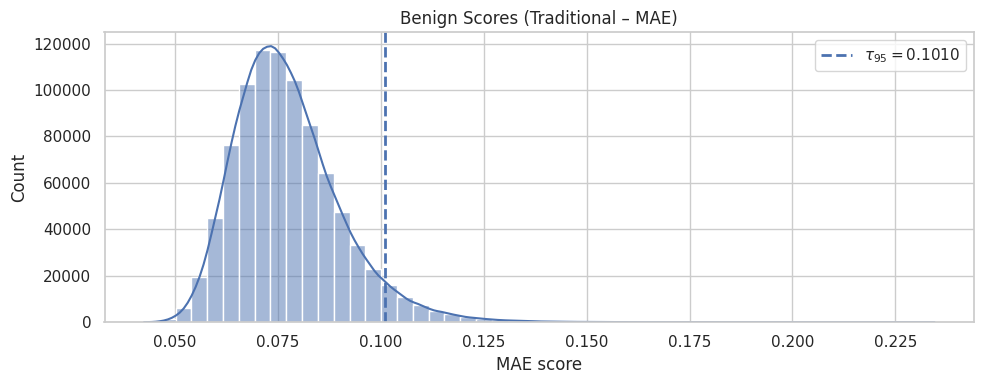

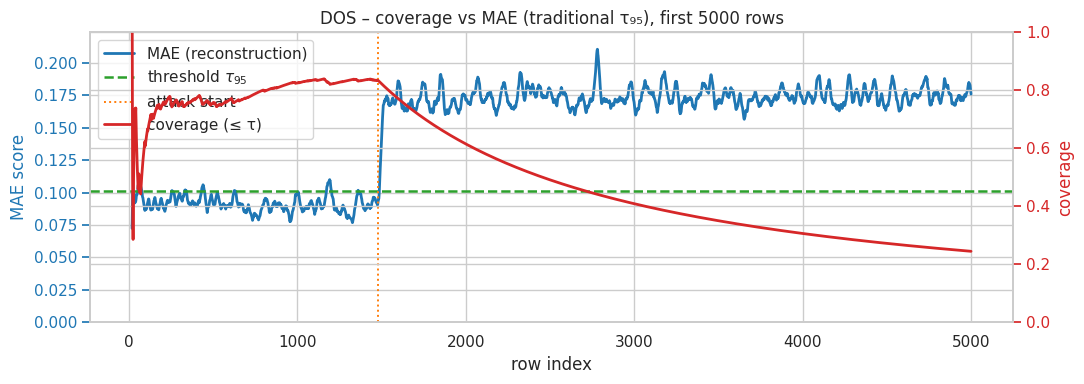

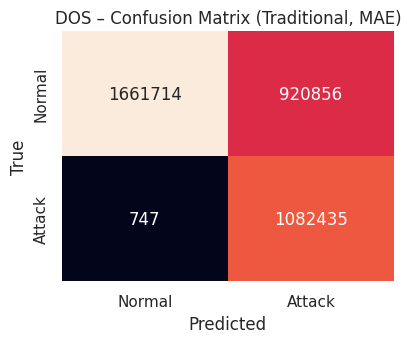

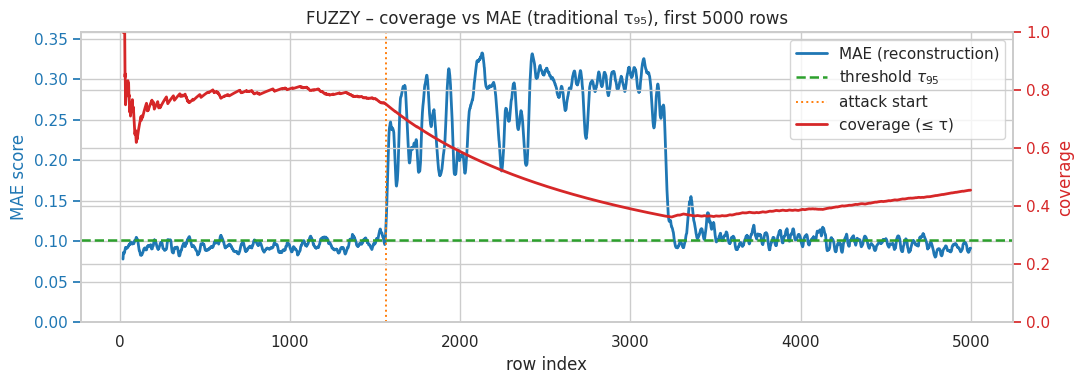

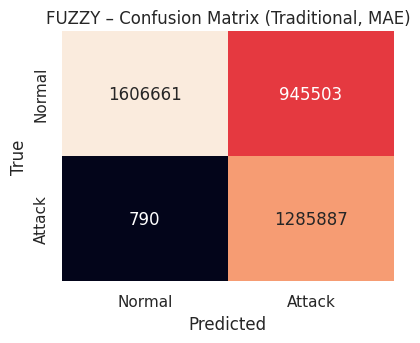

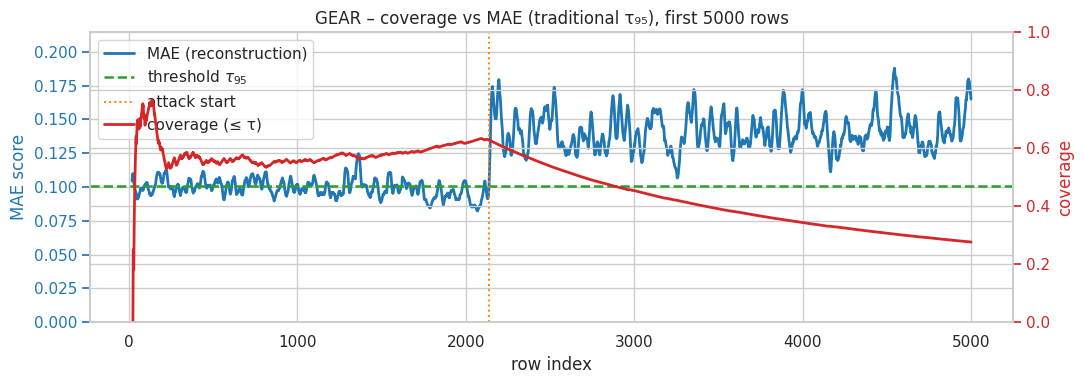

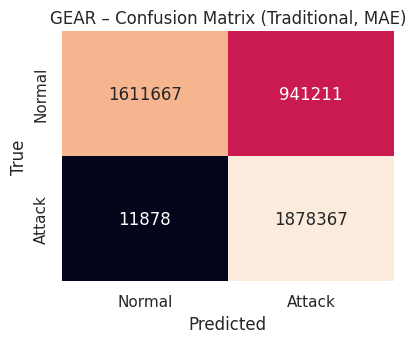

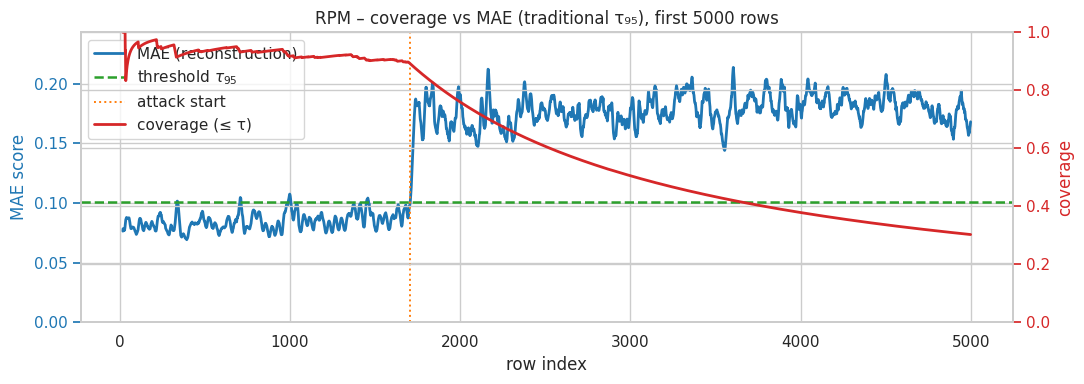

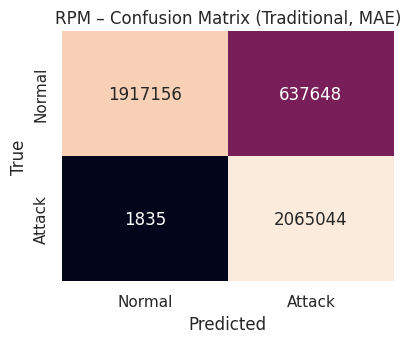

In [51]:
print(f"\n===== Traditional Thresholding ({SELECT_SCORE}) =====")
df_trad  = evaluate_traditional_thresholding(SELECT_SCORE)


===== Standard Conformal (MAE) =====


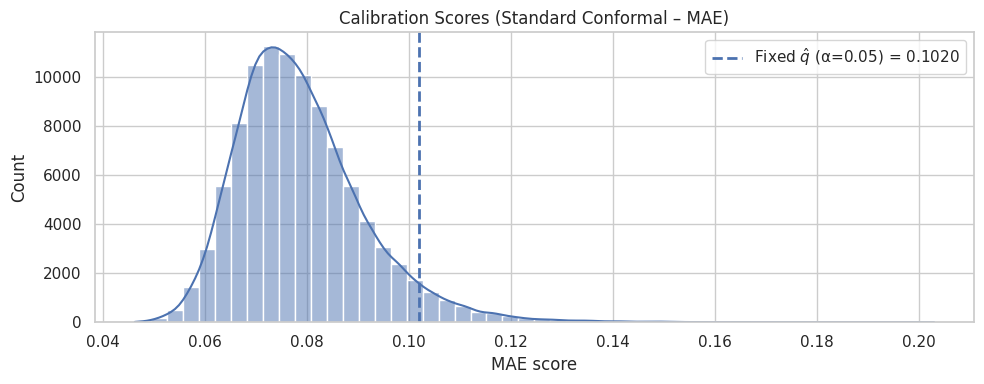

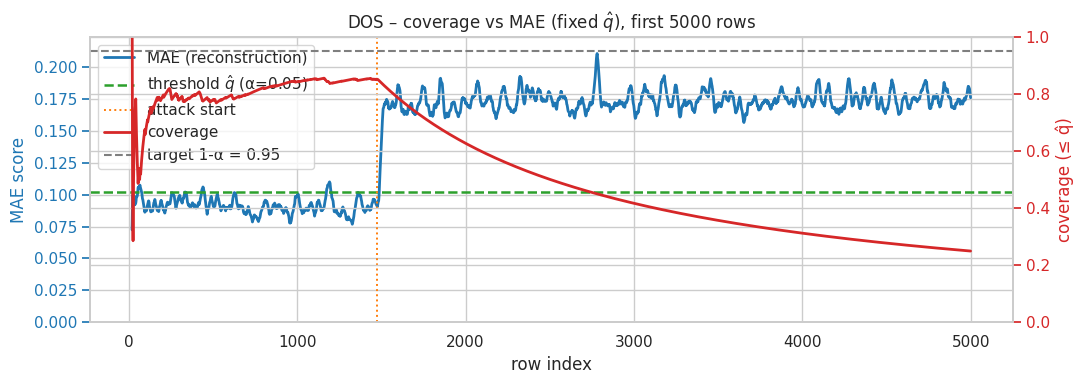

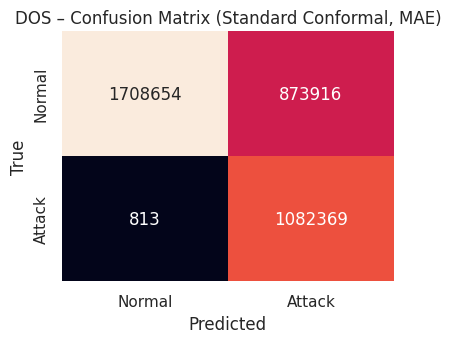

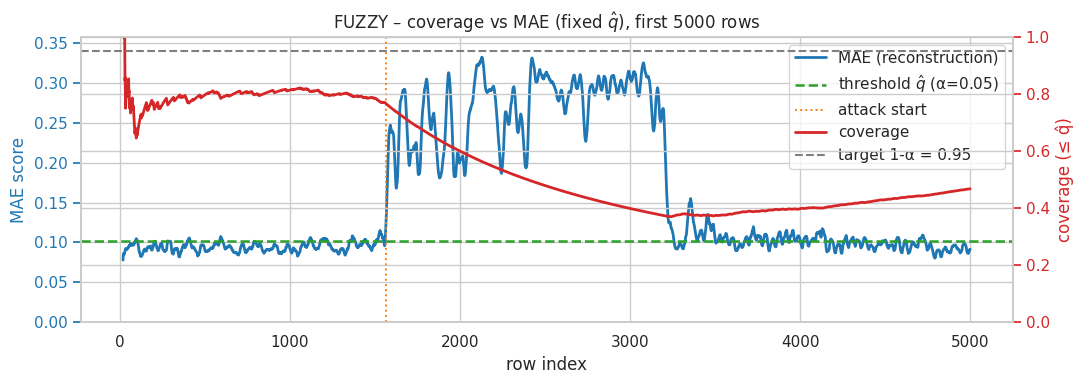

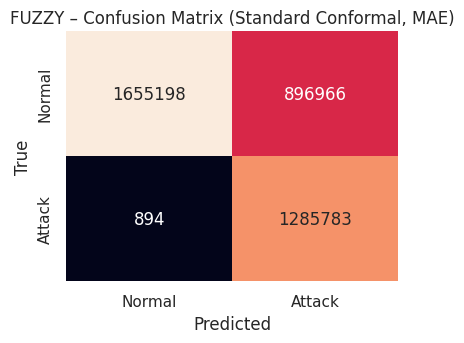

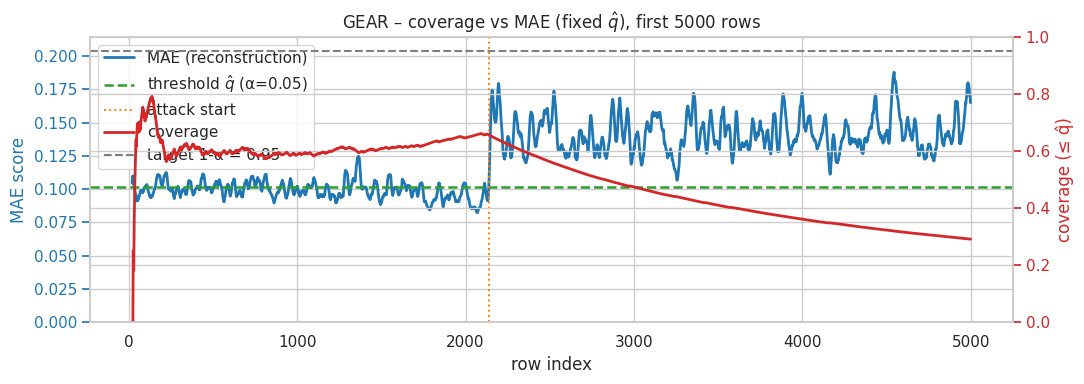

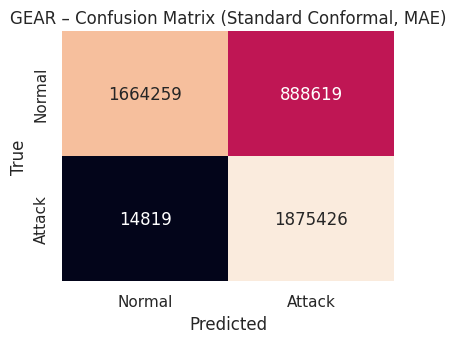

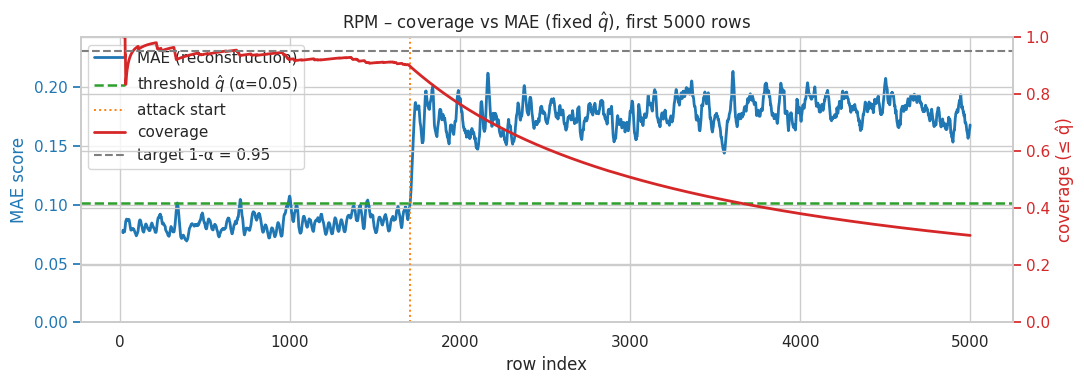

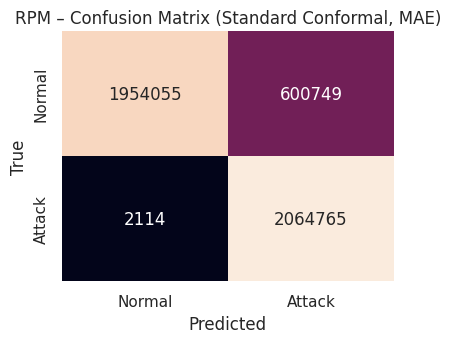

In [52]:
print(f"\n===== Standard Conformal ({SELECT_SCORE}) =====")
df_std   = evaluate_standard_conformal(SELECT_SCORE)


===== Adaptive Conformal (MAE) =====


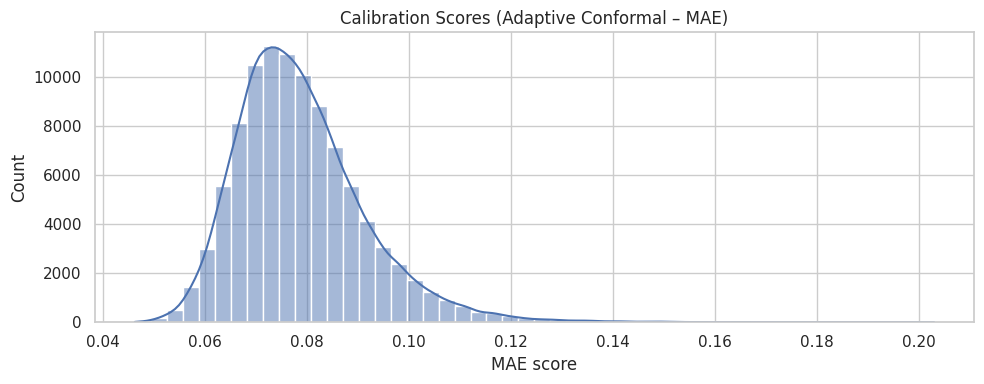

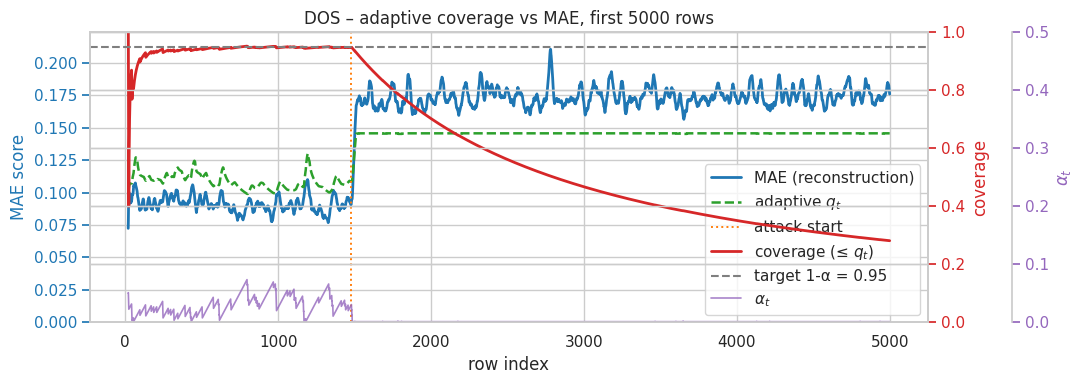

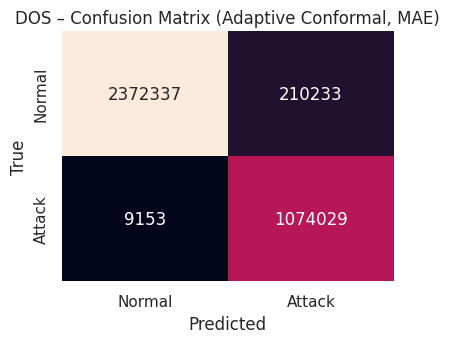

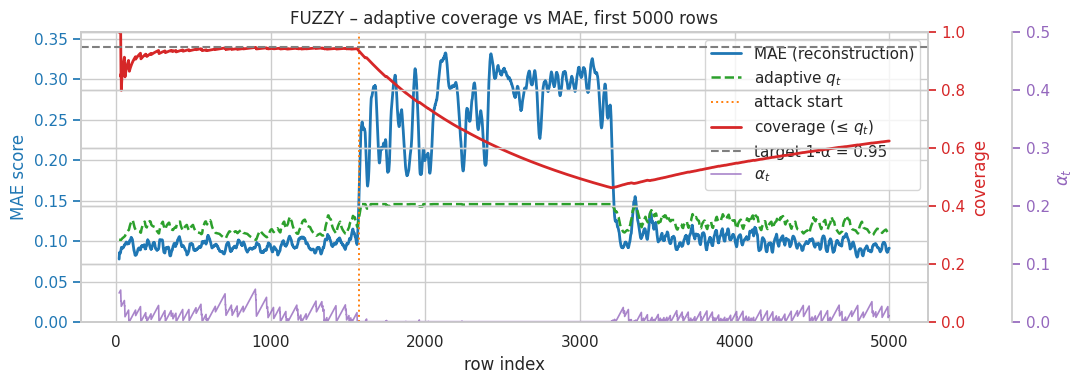

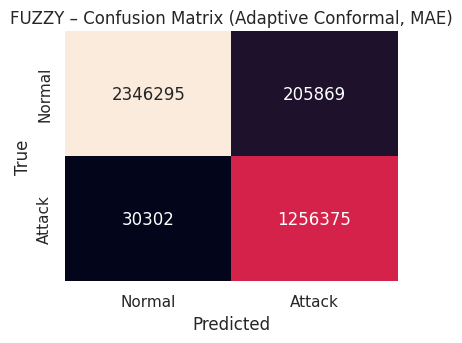

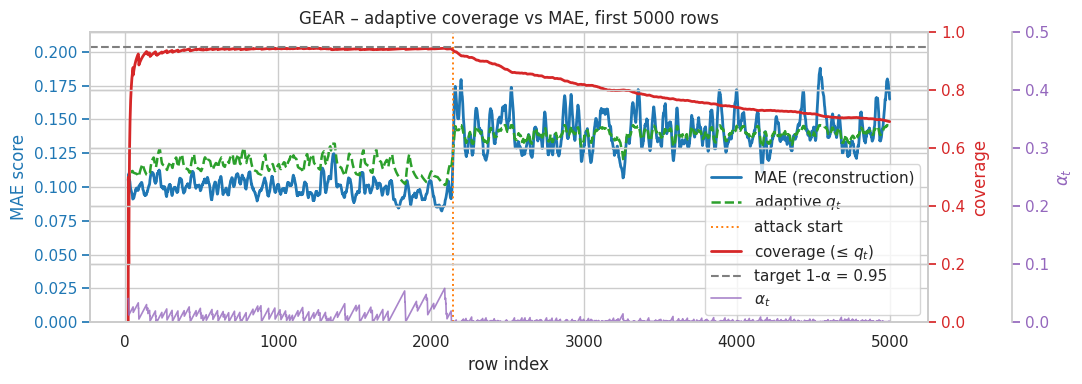

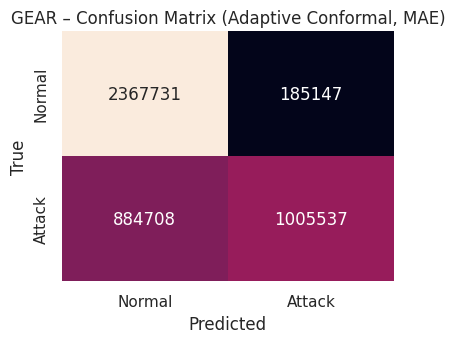

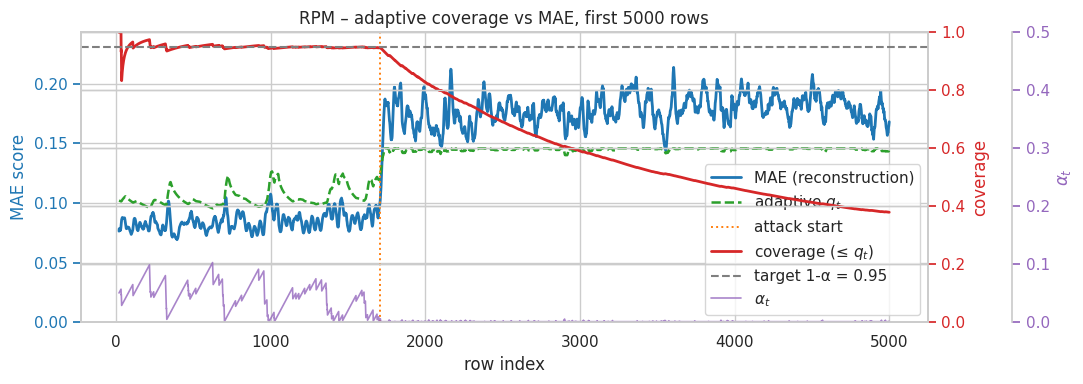

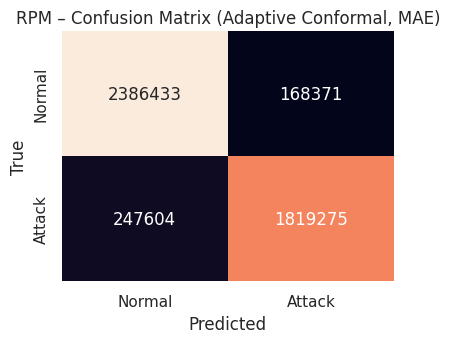

In [53]:
print(f"\n===== Adaptive Conformal ({SELECT_SCORE}) =====")
df_adapt = evaluate_adaptive_conformal(SELECT_SCORE)

In [54]:
all_df = [x for x in [df_trad, df_std, df_adapt] if x is not None and not x.empty]
final_df = pd.concat(all_df, ignore_index=True) if all_df else pd.DataFrame()

cols = ["type","mode","dataset","num_seqs","threshold","q_fixed","acc","prec","rec","f1","tn","fp","fn","tp"]
final_df = final_df.reindex(columns=[c for c in cols if c in final_df.columns])

display(final_df)
final_df.to_csv(ARTIFACTS / f"final_metrics_{SELECT_SCORE.lower()}.csv", index=False)
print(f"[saved] {ARTIFACTS / f'final_metrics_{SELECT_SCORE.lower()}.csv'}")

,type,mode,dataset,num_seqs,threshold,acc,prec,rec,f1,tn,fp,fn,tp
0,traditional,MAE,dos,3665752,0.101028,0.748591,0.540328,0.999310,0.701406,1661714,920856,747,1082435
1,traditional,MAE,fuzzy,3838841,0.101028,0.753495,0.576272,0.999386,0.731019,1606661,945503,790,1285887
2,traditional,MAE,gear,4443123,0.101028,0.785491,0.666187,0.993716,0.797638,1611667,941211,11878,1878367
3,traditional,MAE,rpm,4621683,0.101028,0.861634,0.764069,0.999112,0.865924,1917156,637648,1835,2065044
4,standard,MAE,dos,3665752,0.101958,0.761378,0.553278,0.999249,0.712210,1708654,873916,813,1082369
5,standard,MAE,fuzzy,3838841,0.101958,0.766112,0.589066,0.999305,0.741208,1655198,896966,894,1285783
6,standard,MAE,gear,4443123,0.101958,0.796666,0.678508,0.992160,0.805891,1664259,888619,14819,1875426
7,standard,MAE,rpm,4621683,0.101958,0.869558,0.774622,0.998977,0.872609,1954055,600749,2114,2064765
8,adaptive,MAE,dos,3665752,NaN,0.940153,0.836301,0.991550,0.907332,2372337,210233,9153,1074029
9,adaptive,MAE,fuzzy,3838841,NaN,0.938479,0.859210,0.976449,0.914086,2346295,205869,30302,1256375


[saved] /home/student/Anthony/can/CAN-bus-conformal-IDS/artifacts/final_metrics_mae.csv
